In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import batman
import emcee
from scipy import optimize

In [33]:
np.random.seed(100)


In [34]:
#System
#http://exoplanets.org/detail/Kepler-19_b
#Semi-Major Axis[au]	0.0846 ± 0.00141
#Orbital Period[day]	9.2869944 ± 8.8×10-6
#Orbit Inclination[deg]	89.94 +0.15/-0.35
#Planetary Radius[rjupiter]	0.1971 ± 0.0043
#Radius of Star[rsun]	0.850 ± 0.018

#Star
#Teff[k]	5541 ± 60
#[Fe/H]	-0.130 ± 0.06
#log10(g)	4.59 ± 0.1
#Using - https://astroutils.astronomy.osu.edu/exofast/limbdark.shtml
#Kepler bandpass
#Quadratic coefficients:
#   0.43135341      0.24553668


#TESS has a cadence of 2 minutes
#0.2 of a day has 144 measurements

In [35]:
def radius_in_stellar_radii(R_planet, R_star):
    """
    Convert planetary radius (R_Jupiter) in stellar radii.
    
    Parameters
    ----------
    R_planet : float
        Planetary radius in R_Jupiter.

    R_star : float
        Stellar radius in R_sun.

    Returns
    -------
    R_planet_stellar_radii : float 
        Planetary radius in stellar radii.

    """
    # 1 R_Jupiter = 0.102763 R_sun

    R_planet_stellar_radii = R_planet * 0.102763 / R_star

    return R_planet_stellar_radii

In [36]:
def semi_major_axis_in_stellar_radii(semi_major_axis, R_star):
    """
    Converting the semi-major axis (AU) to (Stellar radii)

    Parameters
    ----------
    semi_major_axis : float
        Semi-major axis of the planet in AU.

    R_star : float
        Stellar radius in R_sun.

    Returns
    -------
    a_stellar_radii : float
        Semi-major axis of the planet in stellar radii
    """
    #1 AU = 215.032 R_Sun

    a_stellar_radii = semi_major_axis * 215.032 / R_star #Check this

    return a_stellar_radii

In [37]:
true_R_star = 0.850 #R_sun
true_R_planet = 0.1971 #R_J
true_semi_major_axis = 0.0846 #AU 


params = batman.TransitParams()
params.t0 = 0.                                          #time of inferior conjunction
params.per = 9.2869944                                        #orbital period (days)
params.rp = radius_in_stellar_radii(true_R_planet, true_R_star)                #planet radius (in units of stellar radii)
params.a = semi_major_axis_in_stellar_radii(true_semi_major_axis, true_R_star) #semi-major axis (in units of stellar radii))
params.inc = 89.94                                      #orbital inclination (in degrees)
params.ecc = 0.0                                         #eccentricity
params.w = 90.                                          #longitude of periastron (in degrees)
params.limb_dark = "quadratic"                          #limb darkening model
params.u = [0.43135341, 0.24553668]                             #limb darkening coefficients [u1, u2, u3, u4]

t = np.linspace(-0.1, 0.1, 144)                      #times at which to calculate light curve
m = batman.TransitModel(params, t)                      #initializes model
true_flux = m.light_curve(params)

In [38]:
#Add noise to the signal
sigma = 0.00001
yerrs = np.random.normal(loc=0., scale=sigma, size=len(true_flux))
true_flux += yerrs

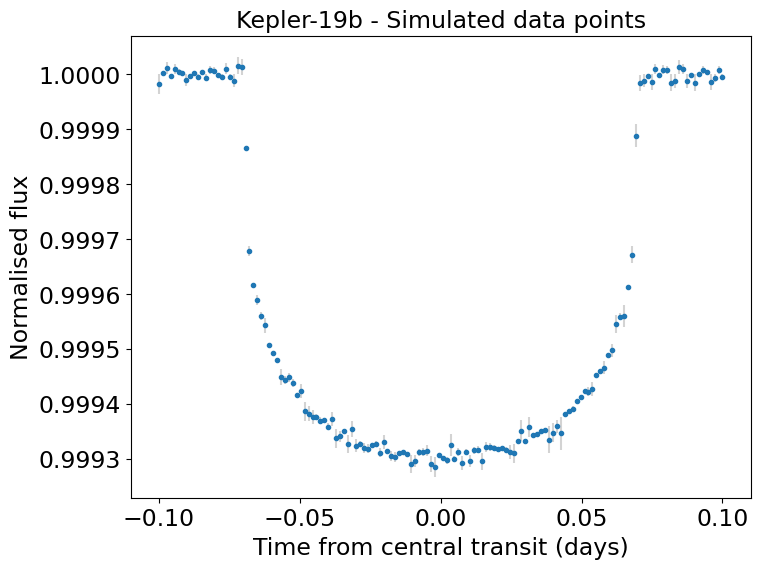

In [39]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.title("Kepler-19b - Simulated data points", size=17)
plt.errorbar(t, true_flux, yerr=yerrs, fmt='.', ecolor='LightGrey', label="Expected")
plt.xlabel("Time from central transit (days)", size=17)
plt.ylabel("Normalised flux", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)
plt.show()

In [40]:

guess_params = batman.TransitParams()
guess_params.t0 = params.t0


guess_params.ecc = params.ecc
guess_params.w = params.w
guess_params.limb_dark = "quadratic"
guess_params.u = params.u

In [41]:
def log_likelihood(params, true_flux, yerrs):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    orbital_inclination, R_planet, semi_major_axis, period = params

    guess_params.per = period
    guess_params.rp = radius_in_stellar_radii(R_planet, true_R_star)
    guess_params.inc = orbital_inclination
    guess_params.a = semi_major_axis_in_stellar_radii(semi_major_axis, true_R_star)

    
    guess_m = batman.TransitModel(guess_params, t)
    guess_flux = guess_m.light_curve(guess_params)
        
    L1 = -0.5 * np.power((true_flux - guess_flux), 2) / np.power(yerrs, 2)
    L2 = (len(t) / 2) * np.log(2 * np.pi * yerrs**2) 
    L3 = np.sum(L1) + np.sum(L2)
    return L3


def log_prior(params):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    orbital_inclination, R_planet, semi_major_axis, period = params

    P = 0.0
    if (orbital_inclination > 90) or (orbital_inclination < 45):
        P += -np.inf
        return -np.inf
    
    if (R_planet < 0):
        P += -np.inf
        return P

    if (semi_major_axis < 0):
        P += -np.inf
        return P
    
    if (period < 0):
        P += -np.inf
        return P

    return P

def log_prob(params, true_flux, yerrs):
    lp = log_prior(params)
    # if not np.isfinite(lp):
    #     return -np.inf

    return -(log_likelihood(params, true_flux, yerrs)) + -1*(lp)

In [42]:
guess = [88, 0.18, 0.08, 9]

likelihood_model = optimize.minimize(log_prob, guess, args=(true_flux, yerrs))
model_orbital_inclination, model_R_planet, model_semi_major_axis, model_period = (likelihood_model['x'])
print(likelihood_model)



      fun: 6908999.452698453
 hess_inv: array([[ 9.99257197e-01,  3.11899203e-03,  2.70649964e-02,
        -9.37071233e-05],
       [ 3.11899203e-03,  9.87212326e-06,  8.57429397e-05,
         3.69527429e-04],
       [ 2.70649964e-02,  8.57429397e-05,  7.44752666e-04,
         3.41710328e-03],
       [-9.37071233e-05,  3.69527429e-04,  3.41710328e-03,
         9.99988178e-01]])
      jac: array([ 5.89631250e+03,  8.01971300e+07, -9.03959981e+06,  5.57443750e+03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 62
      nit: 2
     njev: 9
   status: 2
  success: False
        x: array([8.80019542e+01, 1.90363007e-01, 6.64200448e-03, 9.00024688e+00])


c:\Users\Student\anaconda3\envs\MSci_project\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\Student\anaconda3\envs\MSci_project\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\Student\anaconda3\envs\MSci_project\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [43]:
pos = likelihood_model.x + 1e-4 * np.random.randn(32, 4)

nwalkers, ndim = pos.shape
pos = np.random.rand(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(true_flux, yerrs))
sampler.run_mcmc(pos, 100, progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Student\anaconda3\envs\MSci_project\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [00:00<00:00, 258.10it/s]


State([[1.38448924e-01 7.78036552e-01 9.21331794e-01 9.43018632e-01]
 [7.04435797e-01 6.93916445e-01 5.46551813e-01 3.69217230e-01]
 [9.82467575e-01 6.56092254e-02 8.97678311e-01 2.63930989e-01]
 [5.74475842e-01 5.12866268e-01 5.54476808e-01 6.47167332e-01]
 [1.85474159e-01 2.71978204e-01 1.48438658e-01 3.03041706e-02]
 [9.39255584e-01 3.46754130e-01 1.09564604e-01 3.78326996e-01]
 [3.84079459e-01 6.65423688e-01 2.44490929e-01 6.61480974e-01]
 [9.84928838e-02 5.80862748e-01 1.06865505e-01 5.48254507e-01]
 [5.19751708e-01 2.96234118e-01 4.55729051e-01 3.86665201e-02]
 [5.99003025e-01 4.86759475e-04 5.01813594e-01 5.01726122e-01]
 [6.06696959e-02 9.49836939e-01 6.08659045e-01 6.72002684e-01]
 [4.62773524e-01 7.04273095e-01 1.81067141e-01 6.47582177e-01]
 [5.68108735e-01 9.54138315e-01 7.96690239e-01 5.85310393e-01]
 [4.55354967e-01 7.38451531e-01 8.12236278e-01 9.27291174e-01]
 [8.26375607e-01 2.99565977e-02 7.72802822e-01 5.21777394e-01]
 [8.85387332e-01 4.58561667e-01 5.40722576e-01 9.

Text(0.5, 0, 'step number')

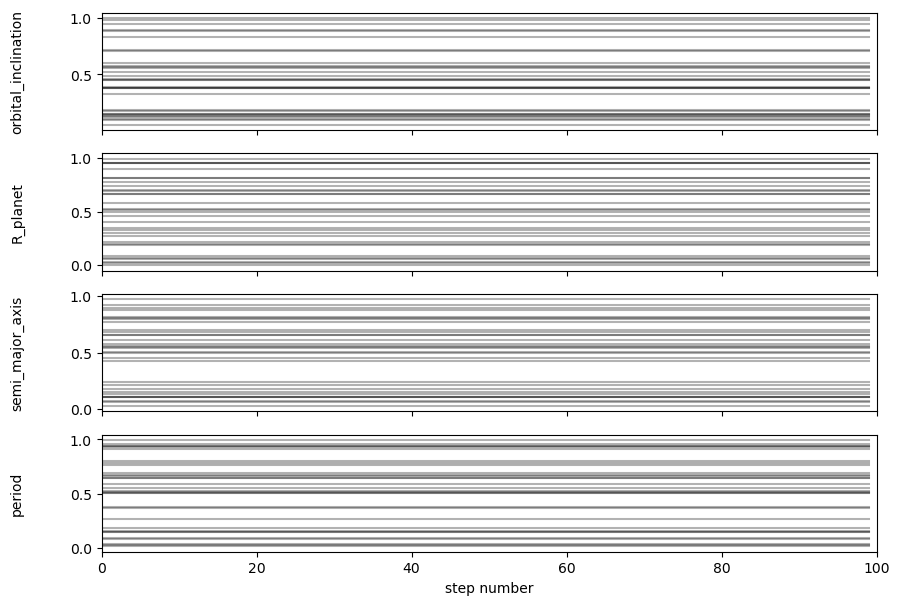

In [44]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

labels = ["orbital_inclination", "R_planet", "semi_major_axis", "period"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [45]:
tau = sampler.get_autocorr_time()
print(tau)

[nan nan nan nan]


c:\Users\Student\anaconda3\envs\MSci_project\lib\site-packages\emcee\autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


In [46]:
model_params = batman.TransitParams()
model_params.t0 = params.t0
model_params.per = params.per
model_params.rp = radius_in_stellar_radii(model_R_planet, true_R_star)
model_params.a = semi_major_axis_in_stellar_radii(model_semi_major_axis, true_R_star)
model_params.inc = model_orbital_inclination
model_params.ecc = params.ecc
model_params.w = params.ecc
model_params.limb_dark = "quadratic"
model_params.u = params.u


model_m = batman.TransitModel(model_params, t)                      #initializes model
model_flux = model_m.light_curve(model_params)

In [47]:
residual = true_flux - model_flux

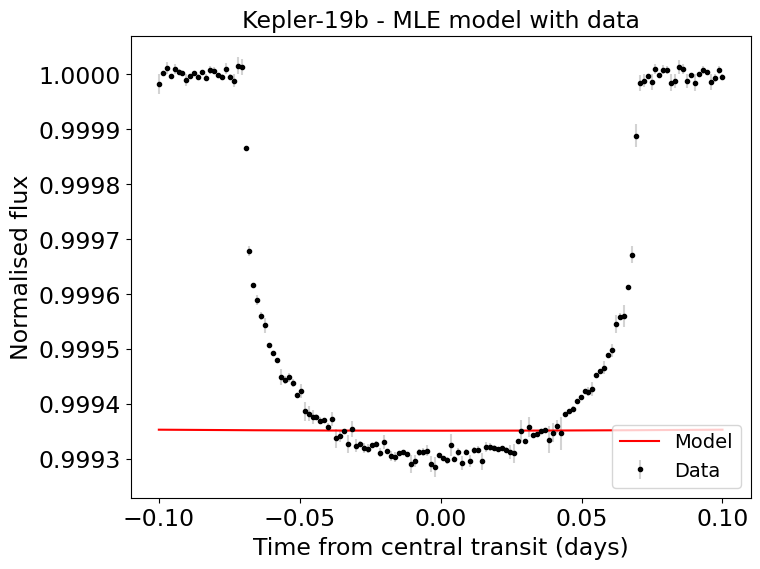

In [48]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.title("Kepler-19b - MLE model with data", size=17)
plt.errorbar(t, true_flux, yerr=yerrs, fmt='.', ecolor='LightGrey', color="black", label="Data")
plt.plot(t, model_flux, label="Model", color="red")
plt.xlabel("Time from central transit (days)", size=17)
plt.ylabel("Normalised flux", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)
ax.legend(prop={'size': 14}, loc="lower right")

plt.show()

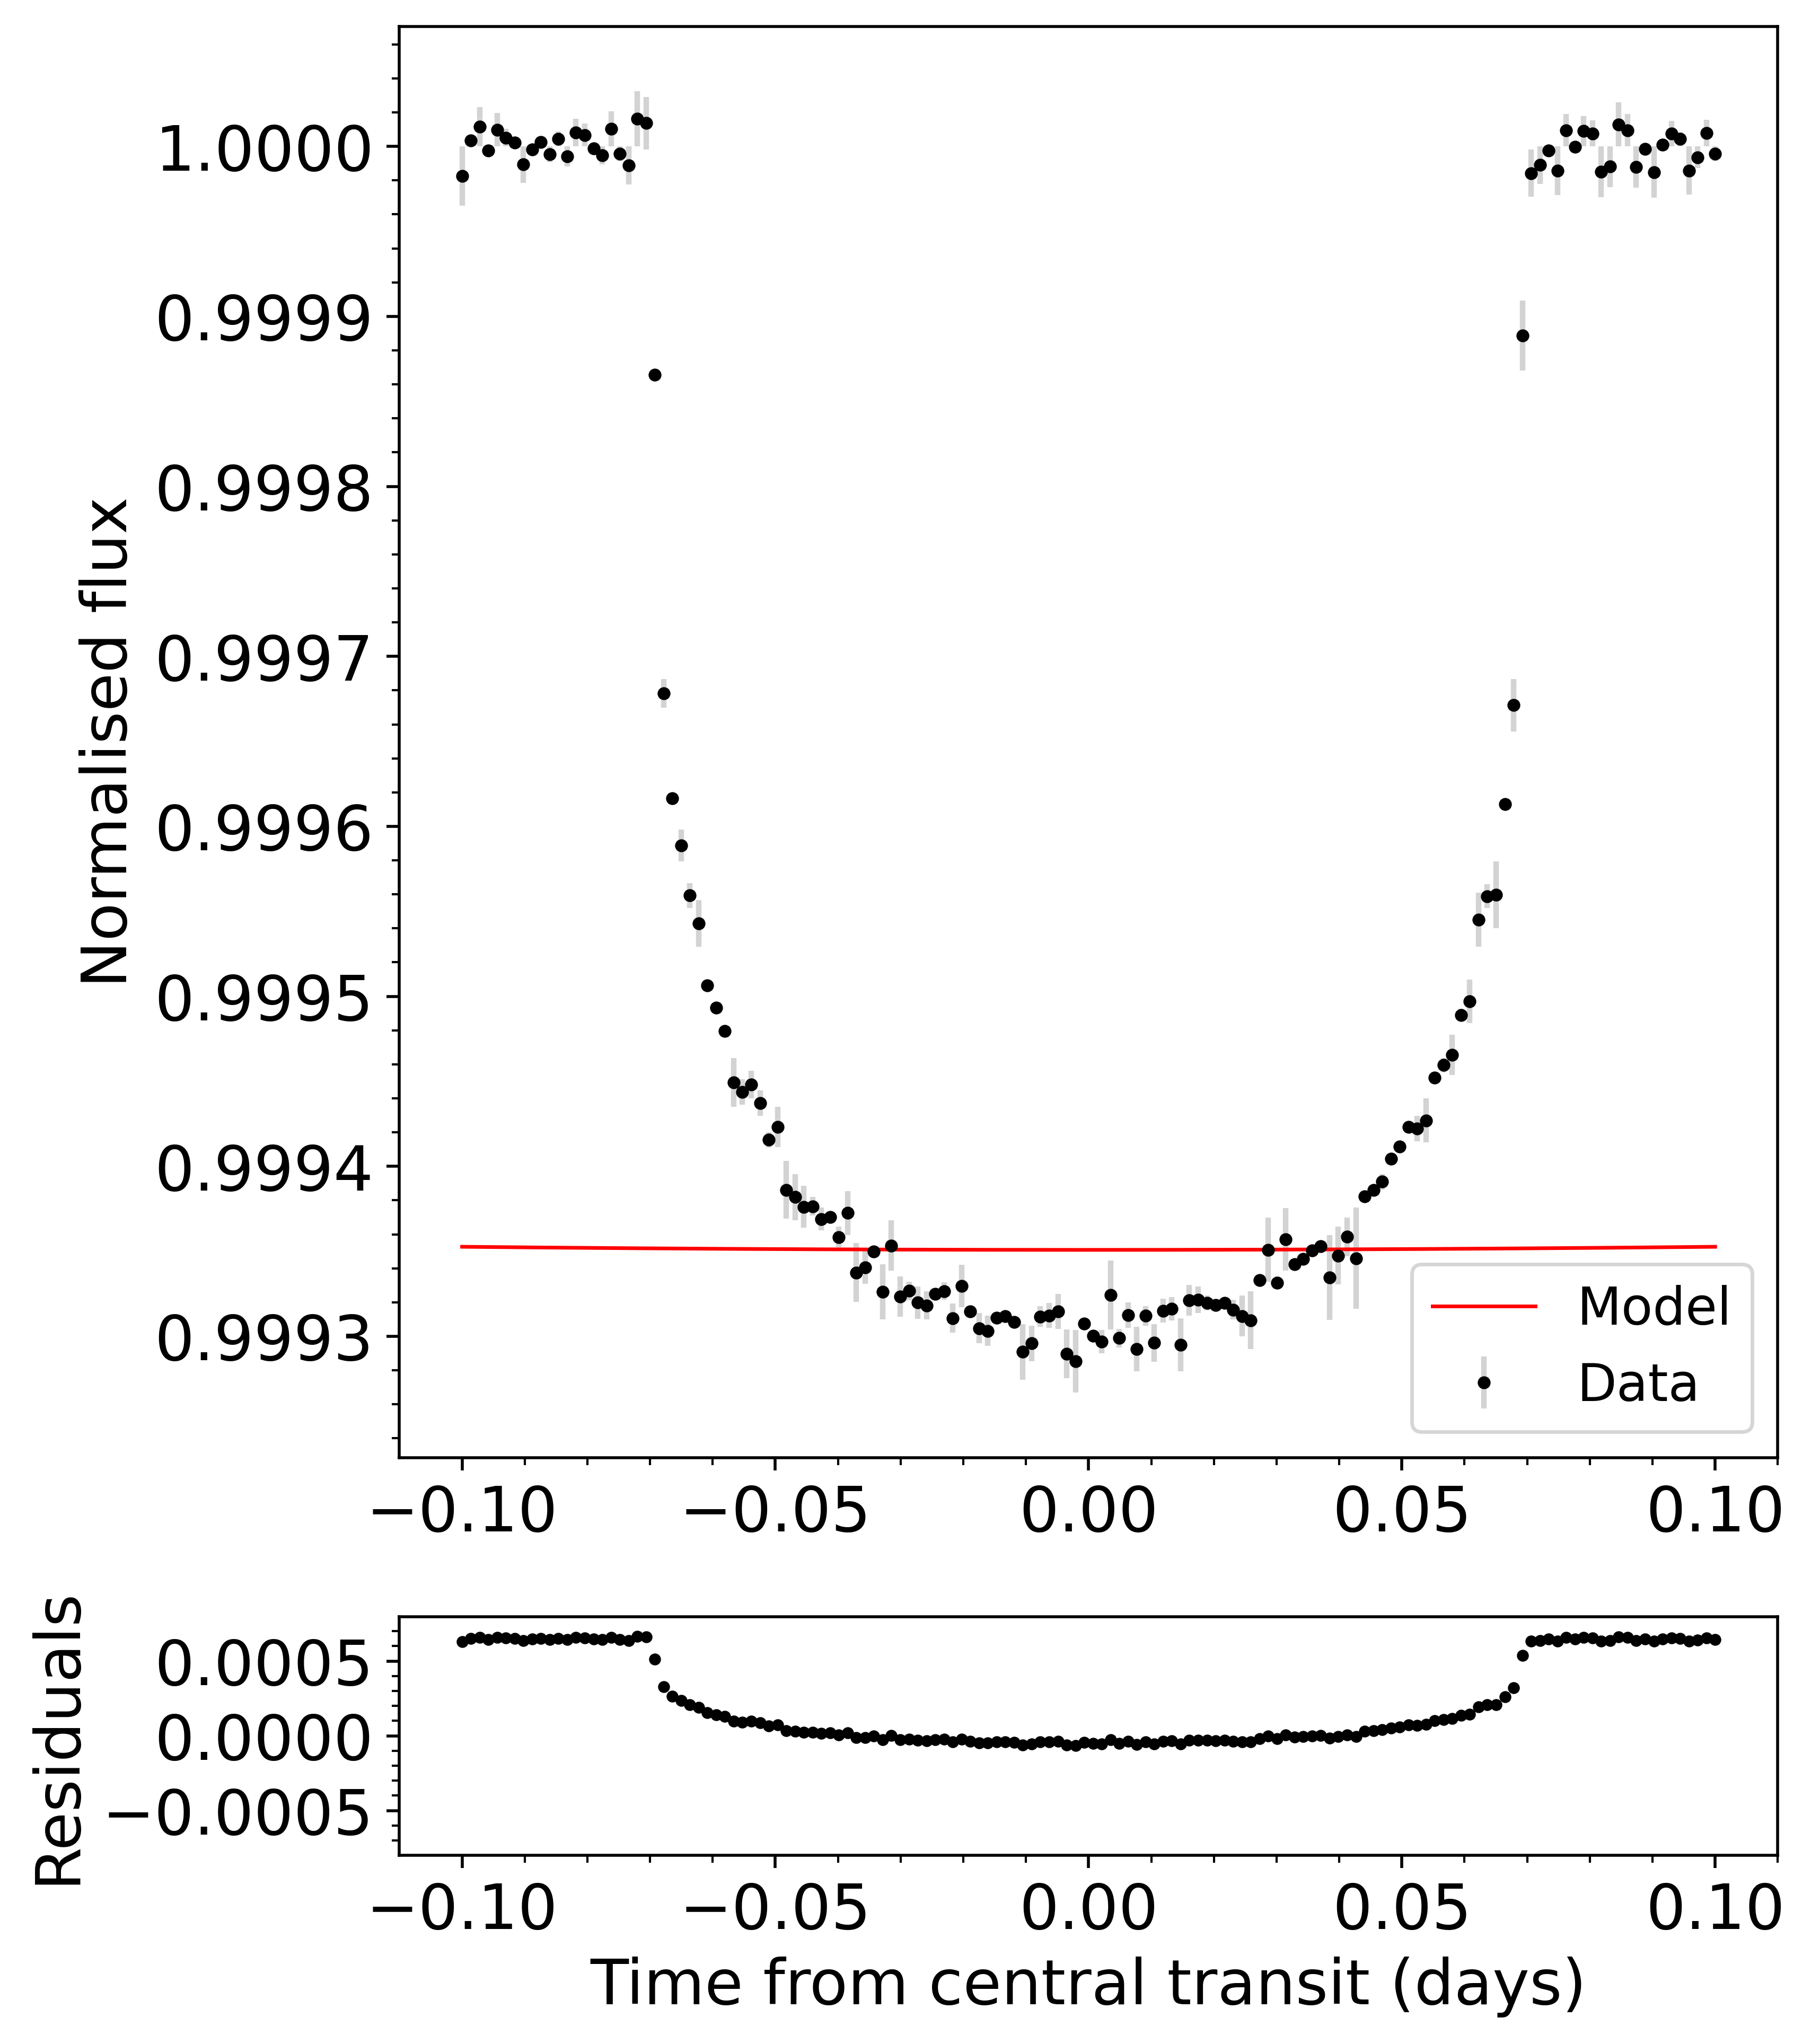

In [49]:
#Panel settings
left = 0.1
bottom = 0.1
width = 0.65
height = 0.9
spacing = -1.15

rect = [left, bottom, width, height]
rect_res = [left, bottom+height+spacing, width, 0.15]

fig = plt.figure(figsize=(8, 6), dpi=500)
ax = fig.add_axes(rect)

ax_res = fig.add_axes(rect_res, sharex=ax)

#Top panel
ax.errorbar(t, true_flux, yerr=yerrs, fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data")
ax.plot(t, model_flux, color='red',label="Model", lw=1)

ax.set(ylabel="Normalised flux")
ax.xaxis.label.set_size(17)
ax.yaxis.label.set_size(17)

ax.legend(prop={'size': 14}, loc="lower right")

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

#Bottom panel
ax_res.scatter(t, residual, color='black', s=5)
ax_res.set_ylim((-max(abs(residual))*1.2, max(abs(residual)*1.2)))
# ax_res.plot([min(t), max(t)], [0, 0], color='red', lw=1)

ax_res.set(xlabel="Time from central transit (days)", ylabel="Residuals")
ax_res.xaxis.label.set_size(17)
ax_res.yaxis.label.set_size(17)

ax_res.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax_res.xaxis.set_tick_params(labelsize=17)
ax_res.yaxis.set_tick_params(labelsize=17)

# fig.subplots_adjust(hspace=0.1)
plt.show()